<a href="https://colab.research.google.com/github/Nkashyap-anand/MNIST-hand-written-digits/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We'll use the famous MNIST Handwritten Digits Database as our training dataset. It consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. 

In [2]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [3]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
len(dataset)

60000

The dataset has 60,000 images that we'll use to train the model. There is also an additional test set of 10,000 images used for evaluating models and reporting metrics in papers and reports. We can create the test dataset using the MNIST class by passing train=False to the constructor.

In [5]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [6]:
#Let's look at a sample element from the training dataset.

dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FF178EA2B50>, 5)

It's a pair, consisting of a 28x28px image and a label. The image is an object of the class PIL.Image.Image, which is a part of the Python imaging library Pillow. 

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

The statement %matplotlib inline indicates to Jupyter that we want to plot the graphs within the notebook. Without this line, Jupyter will show the image in a popup. Statements starting with % are called magic commands and are used to configure the behavior of Jupyter itself.

Label: 5


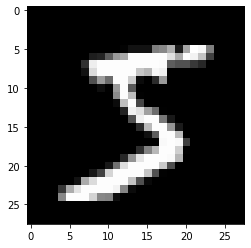

In [8]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [9]:
import torchvision.transforms as transforms

PyTorch datasets allow us to specify one or more transformation functions that are applied to the images as they are loaded. The `torchvision.transforms` module contains many such predefined functions. We'll use the `ToTensor` transform to convert images into PyTorch tensors.

In [10]:
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [11]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB).



In [12]:
#Let's look at some sample values inside the tensor.

print(img_tensor[0,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


The values range from 0 to 1, with 0 representing black, 1 white, and the values in between different shades of grey. We can also plot the tensor as an image using plt.imshow.

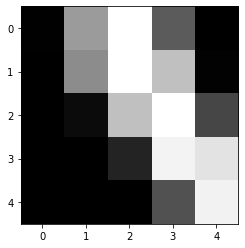

In [13]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

we need to pass just the 28x28 matrix to `plt.imshow`, without a channel dimension. We also pass a color map (`cmap=gray`) to indicate that we want to see a grayscale image.

## Training and Validation Datasets

While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images. 

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the `random_spilt` method from PyTorch.

In [14]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

It's essential to choose a random sample for creating a validation set. Training data is often sorted by the target labels, i.e., images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist of 8s and 9s. In contrast, the training set would contain no 8s or 9s. Such a training-validation would make it impossible to train a useful model.

We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.



In [15]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

We set `shuffle=True` for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process. On the other hand, since the validation data loader is used only for evaluating the model, there is no need to shuffle the images. 

## Model

Now that we have prepared our data loaders, we can define our model.

* A **logistic regression** model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`). 

* As we did with linear regression, we can use `nn.Linear` to create the model instead of manually creating and initializing the matrices.

* Since `nn.Linear` expects each training example to be a vector, each `1x28x28` image tensor is _flattened_ into a vector of size 784 `(28*28)` before being passed into the model. 

* The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [16]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

Let's take a look at the weights and biases.

In [17]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-2.8886e-02, -2.3559e-03, -3.0834e-03,  ..., -5.3180e-04,
         -3.2142e-02,  2.7893e-02],
        [ 1.7593e-02, -1.4993e-02, -3.5756e-04,  ..., -1.6032e-02,
         -9.1061e-03,  2.7508e-05],
        [-2.1639e-02,  9.3508e-03, -2.3460e-02,  ...,  2.2840e-03,
          3.4977e-02,  2.4837e-02],
        ...,
        [ 1.8720e-02, -5.1894e-04,  2.6958e-02,  ..., -6.4440e-03,
          1.8666e-02,  3.0645e-02],
        [-2.3057e-02, -3.2315e-02, -1.4447e-02,  ...,  3.0622e-04,
         -9.0216e-03, -1.5736e-02],
        [-1.0097e-02, -2.9642e-02, -7.9797e-03,  ..., -1.0505e-02,
          5.4490e-03,  2.5282e-02]], requires_grad=True)

In [18]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0250,  0.0173,  0.0298, -0.0279, -0.0053,  0.0169, -0.0343,  0.0195,
        -0.0136, -0.0019], requires_grad=True)

Although there are a total of 7850 parameters here. Let's try and generate some outputs using our model. We'll take the first batch of 100 images from our dataset and pass them into our model.

In [19]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([7, 8, 8, 1, 4, 3, 2, 2, 6, 3, 3, 2, 5, 2, 4, 6, 3, 8, 2, 5, 7, 6, 0, 4,
        3, 6, 6, 1, 5, 1, 5, 0, 1, 6, 0, 2, 5, 5, 1, 2, 1, 1, 7, 1, 2, 0, 3, 1,
        8, 6, 9, 1, 7, 1, 0, 1, 2, 0, 9, 3, 0, 9, 5, 8, 7, 3, 1, 5, 9, 6, 6, 4,
        7, 6, 0, 3, 7, 0, 8, 5, 8, 0, 5, 9, 9, 0, 8, 7, 6, 0, 9, 6, 2, 4, 6, 0,
        8, 0, 2, 5, 3, 2, 1, 3, 0, 8, 2, 7, 7, 4, 0, 0, 3, 9, 6, 7, 4, 9, 2, 1,
        4, 7, 4, 5, 2, 2, 4, 4])
torch.Size([128, 1, 28, 28])


RuntimeError: ignored

In [20]:
images.shape

torch.Size([128, 1, 28, 28])

In [21]:
images.reshape(128, 784).shape

torch.Size([128, 784])

The code above leads to an error because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. We'll use the `.reshape` method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data. To include this additional functionality within our model, we need to define a custom model by extending the `nn.Module` class from PyTorch. 

A class in Python provides a "blueprint" for creating objects. Let's look at an example of defining a new class in Python.

Classes can also build upon or _extend_ the functionality of existing classes. Let's extend the `nn.Module` class from PyTorch to define a custom model.

In [22]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

Inside the `__init__` constructor method, we instantiate the weights and biases using `nn.Linear`. And inside the `forward` method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into `self.linear`.

`xb.reshape(-1, 28*28)` indicates to PyTorch that we want a *view* of the `xb` tensor with two dimensions. The length along the 2nd dimension is 28\*28 (i.e., 784). One argument to `.reshape` can be set to `-1` (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has `.weight` and `.bias` attributes (as they are now inside the `.linear` attribute), but it does have a `.parameters` method that returns a list containing the weights and bias.

In [23]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [24]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 2.0447e-04,  1.1416e-02, -8.9303e-03,  ..., -3.4869e-02,
           1.8372e-02, -2.0227e-02],
         [ 1.9125e-02,  2.7088e-02,  1.2524e-02,  ..., -2.1652e-02,
           1.1516e-02, -4.7527e-03],
         [ 2.2396e-02,  4.9991e-05,  1.2054e-03,  ...,  2.1435e-02,
           3.2843e-02,  2.6466e-02],
         ...,
         [-1.1622e-02, -4.2458e-03,  3.1940e-02,  ...,  2.7075e-02,
           2.7970e-02,  1.7743e-02],
         [ 1.8735e-02, -2.2328e-03,  1.4384e-02,  ..., -1.3806e-02,
           8.0705e-03, -1.4935e-02],
         [ 1.7254e-02, -1.1190e-02,  3.3707e-02,  ..., -1.4496e-02,
           8.1092e-04, -2.1421e-02]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0185, -0.0139, -0.0346, -0.0059,  0.0213, -0.0026,  0.0356,  0.0128,
          0.0267, -0.0288], requires_grad=True)]